In [62]:
import os
import re
import h5py
import random
import numpy as np
import pandas as pd
import scipy.io
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import utils

datadir = '../datasets/NNN/'
fnames = utils.fnames(datadir)
# data = pd.read_pickle('../datasets/NNN/all_unit_data.pkl')
raster_data = pd.read_pickle('../datasets/NNN/unit_data_full.pkl')

EOFError: Ran out of input

unit types: 456
psth: (456, 450)
avg firing rate to all images: (456, 1072)
number of single units: 30


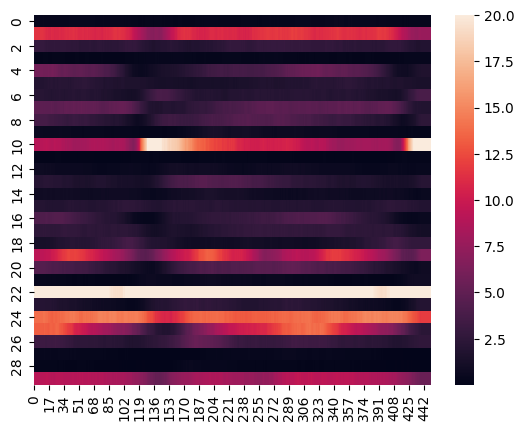

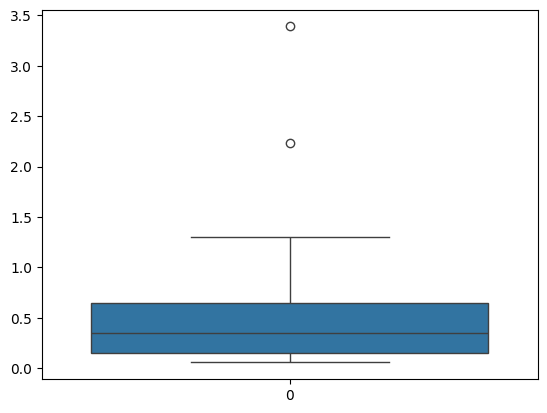

In [27]:
for i, pair in enumerate(fnames):
    if i>0:
        break
    gus_fname = os.path.join(datadir, pair[0])
    proc_fname = os.path.join(datadir, pair[1])
    
    gus_data = utils.load_mat(gus_fname)
    proc_data = scipy.io.loadmat(proc_fname)
    
    print('unit types:', len(proc_data['UnitType'][0]))
    print('psth:', proc_data['mean_psth'].shape)
    print('avg firing rate to all images:', proc_data['response_basic'].shape)
    
    mean_psth = proc_data['mean_psth']
    unit_type = proc_data['UnitType'][0]
    single_units = np.where(unit_type==1)
    snr = proc_data['snr'].T
    response = np.stack(gus_data['GoodUnitStrc']['response_matrix_img'])
    
    print(f'number of single units: {np.sum(unit_type==1)}')
    
    sns.heatmap(mean_psth[single_units], vmax=20)
    plt.show()
    
    sns.boxplot(snr[single_units])
    plt.show()

(-1.0, 50.0)

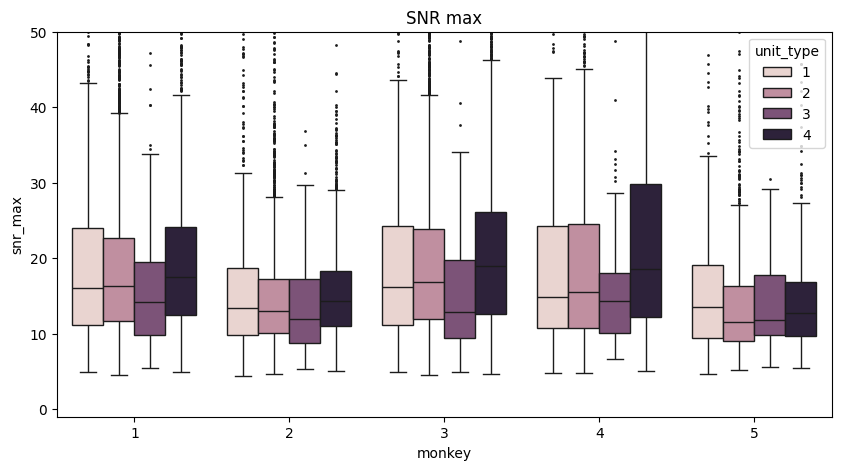

In [105]:
# df = data[data['unit_type']==1]
fig,ax = plt.subplots(1,1,figsize=(10,5))
df = data

sns.boxplot(df, x='monkey', y='snr_max', hue='unit_type', fliersize=1, ax=ax)
plt.title('SNR max')
plt.ylim(bottom = -1, top=50)

In [31]:
df.groupby(['unit_type']).describe()

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


session                                                     \
             count       mean        std  min   25%   50%   75%   max   
unit_type                                                               
1           3016.0  29.585875  17.611467  1.0  16.0  27.0  46.0  59.0   
2          17084.0  30.832299  16.845995  1.0  17.0  32.0  45.0  59.0   
3            621.0  30.446055  17.922838  1.0  17.0  29.0  47.0  59.0   
4           9772.0  31.038887  16.858211  1.0  17.0  31.0  46.0  59.0   

            monkey            ...                snr                      \
             count      mean  ...  75%  max    count      mean       std   
unit_type                     ...                                          
1           3016.0  2.480438  ...  3.0  5.0   3016.0  1.094978  2.956818   
2          17084.0  2.361742  ...  3.0  5.0  17084.0       inf       NaN   
3            621.0  2.623188  ...  3.0  5.0    621.0  0.646743  1.311935   
4           9772.0  2.423148  ...  3.0  5.0   9772.0  1.142537  1.507981   

                                                               
                min       25%       50%       75%         max  
unit_type                                                      
1          0.009018  0.174511  0.404382  1.044136  113.999168  
2         -0.023617  0.282425  0.676887  1.510346         inf  
3          0.034297  0.154417  0.292030  0.684894   20.146711  
4         -0.012834  0.299204  0.654365  1.419283   20.547359  

[4 rows x 24 columns]

[]

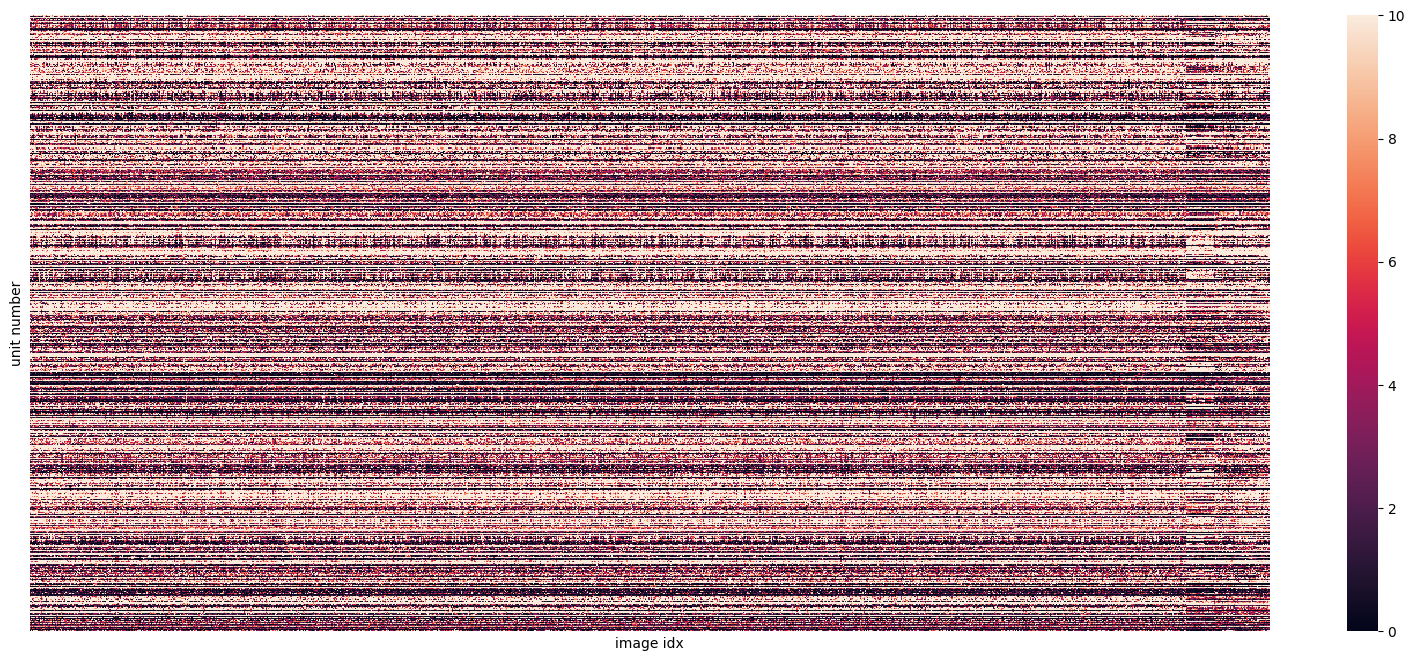

In [80]:
fig,ax = plt.subplots(1,1,figsize=(20,8))

df = data[(data['unit_type']==1) & (data['snr']>1)]
dat = np.stack(df['avg_firing_rate'])

sns.heatmap(dat, ax=ax, vmax=10)

ax.set_ylabel('unit number')
ax.set_xlabel('image idx')
ax.set_xticks([], [])
ax.set_yticks([], [])


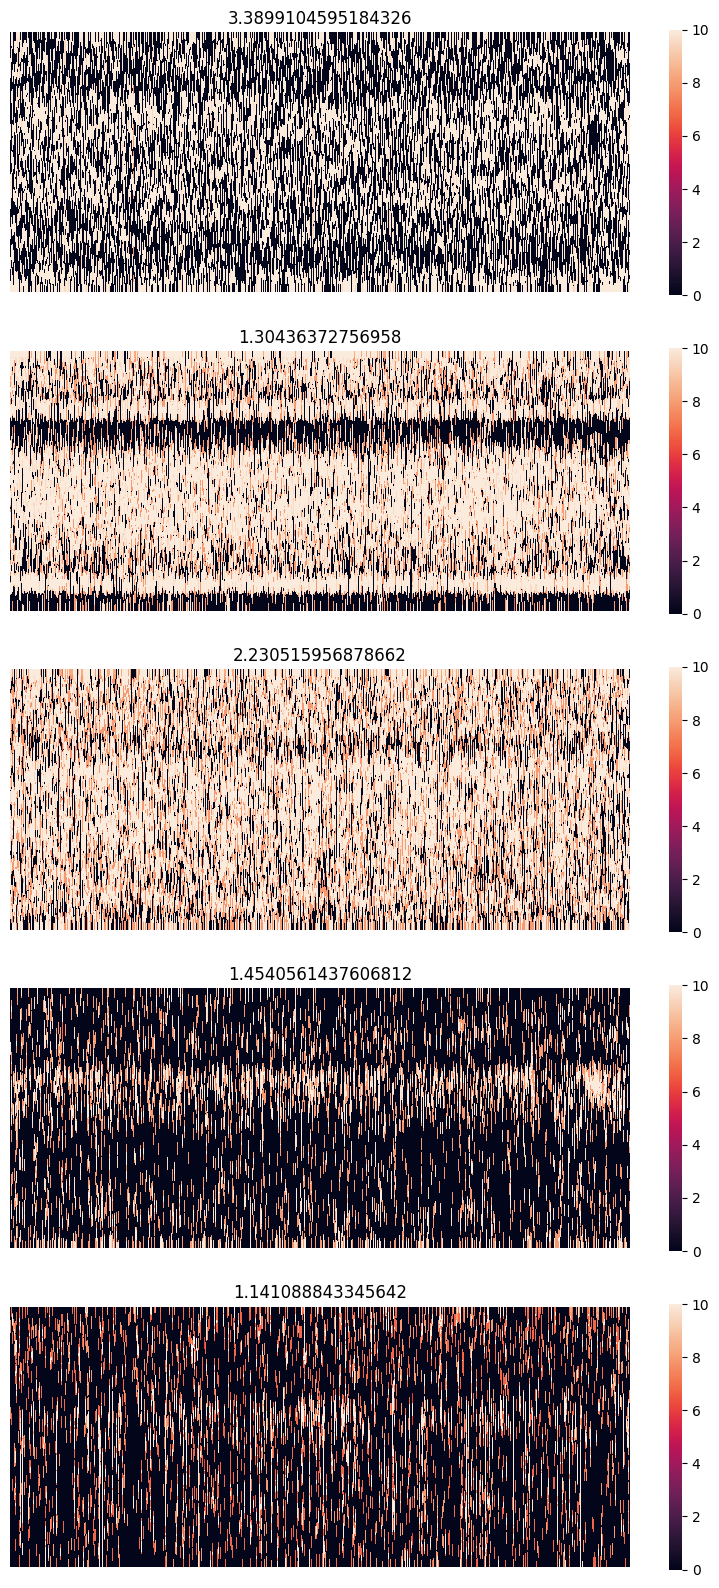

In [66]:
df = data[(data['unit_type']==1) & (data['snr']>1)]

fig,axes = plt.subplots(5,1,figsize=(10,20))

for i in range(5):
    num = round(random.random()*len(df))
    dat = df.iloc[num]['img_psth']
    sns.heatmap(dat, square=True, vmax=10, ax=axes[i])
    axes[i].axis("off")
    axes[i].set_title(f'{df.iloc[i]['snr']}')

In [ ]:
# sample
# df = pd.DataFrame({'F_SI':..., 'B_SI':..., 'O_SI':...})

# 1. "Melt" the dataframe to long form (for lineplotting with seaborn)
df = data.copy()

df_long = df.reset_index().melt(id_vars='index', value_vars=['F_SI', 'B_SI', 'O_SI'],
                                var_name='SI_type', value_name='SI_value')
df_long = df_long.rename(columns={"index": "unit"})  # index serves as unique unit id

# 2. For grouping: For each unit, find which SI_type is maximal AND above cutoff
cutoff = 0.5

# Get for each unit the max SI value and its column
def assign_group(row):
    vals = row[['F_SI', 'B_SI', 'O_SI']]
    maxval = vals.max()
    if maxval < cutoff:
        return 'None'
    maxcol = vals.idxmax()
    return maxcol  # will be 'F_SI', 'B_SI', or 'O_SI'

df['group'] = data.apply(assign_group, axis=1)

# 3. Add 'group' label to long version
df_long['group'] = df_long['unit'].map(df['group'])

# Filter out units not meeting any cutoff
df_long_filtered = df_long[df_long['group'] != 'None']

/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_85664/4111539631.py:7: UserWarning: 
The palette list has fewer values (1) than needed (4671) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(sub_df, x='SI_type', y='SI_value', sort=False,


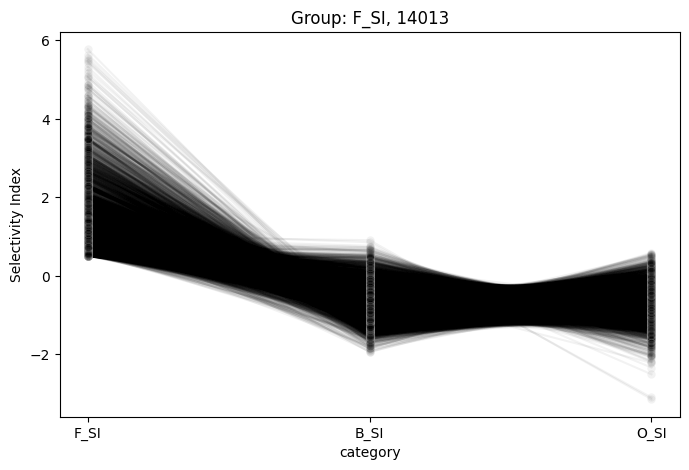

/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_85664/4111539631.py:7: UserWarning: 
The palette list has fewer values (1) than needed (5077) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(sub_df, x='SI_type', y='SI_value', sort=False,


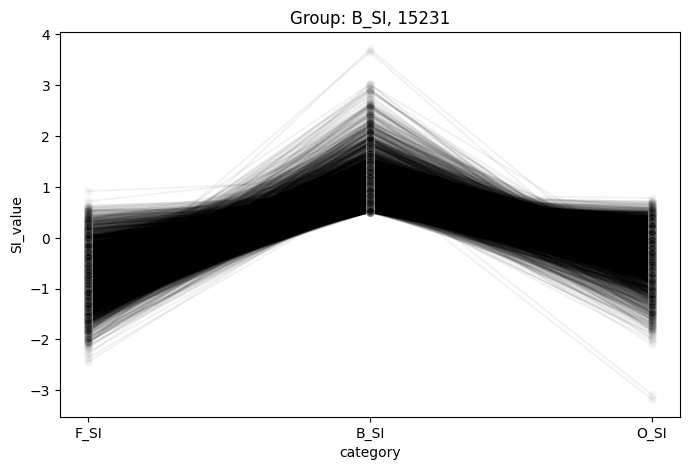

/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_85664/4111539631.py:7: UserWarning: 
The palette list has fewer values (1) than needed (4625) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(sub_df, x='SI_type', y='SI_value', sort=False,


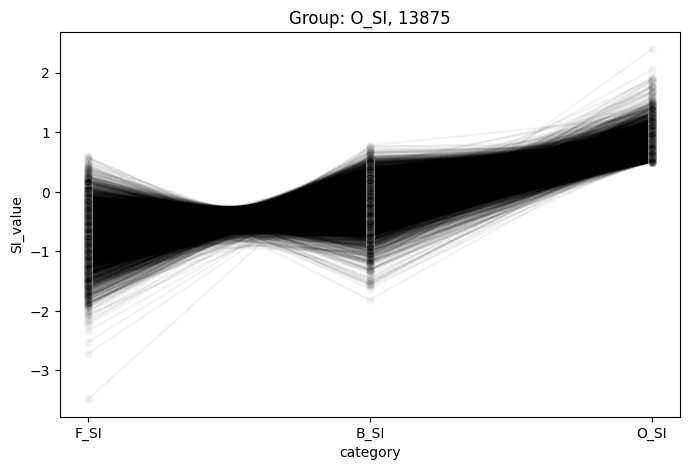

In [168]:
# fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)

groups = ['F_SI', 'B_SI', 'O_SI']
for i, g in enumerate(groups):
    fig,ax = plt.subplots(1,1,figsize=(8,5))
    sub_df = df_long_filtered[df_long_filtered['group'] == g]
    sns.lineplot(sub_df, x='SI_type', y='SI_value', sort=False,
                 hue='unit', marker='o', palette = ['black'], alpha=0.05)
    ax.set_title(f"Group: {g}, {len(sub_df)}")
    ax.legend().remove()
    ax.set_xlabel('category')
    if i == 0:
        ax.set_ylabel('Selectivity Index')
    plt.show()

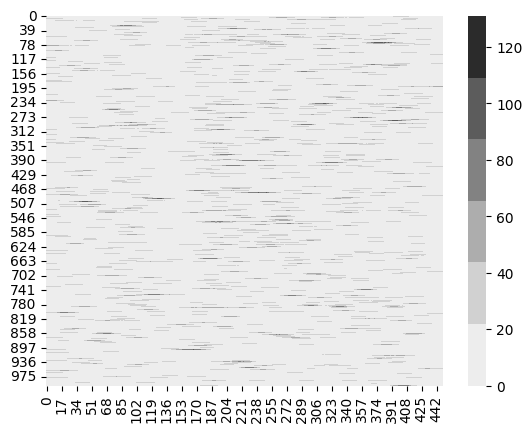

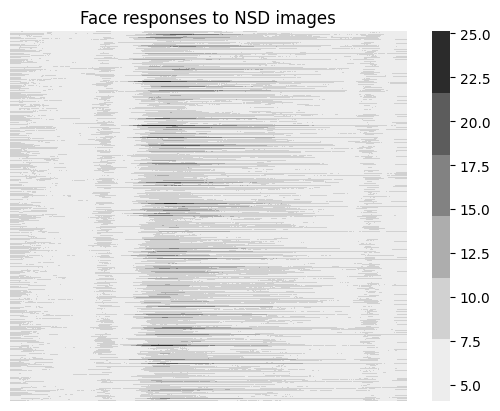

In [7]:
unit = 'F_SI'
face_df = raster_data[(raster_data[unit]>0.5) & (raster_data['unit_type'] == 1)]
face_df = face_df[~(face_df['img_raster'].isna())] # some sessions do not have raster data?
psth = face_df.iloc[13]['img_psth']
sns.heatmap(psth[:, :1000].T, cmap=sns.color_palette(palette='Greys'))
plt.show()

x = np.stack(face_df['img_psth'].values)
avg_face = np.mean(x, axis=0)
sns.heatmap(avg_face[:, :1000].T, cmap=sns.color_palette(palette='Greys'))
plt.title('Face responses to NSD images')
plt.axis('off')
plt.show()

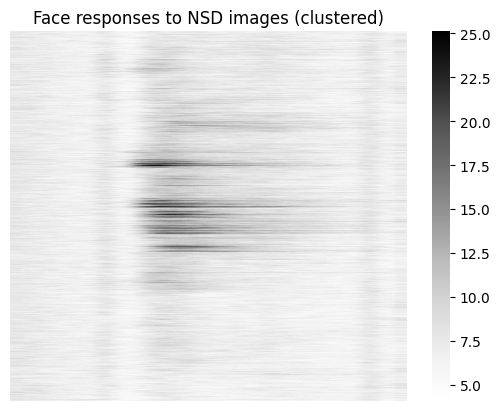

In [9]:
M = avg_face[:, :1000].T  # (1000, time)

# 1. Compute row linkage (using, e.g., Euclidean or correlation distance)
dists = pdist(M, metric='correlation')  # or 'euclidean', 'cosine', etc
row_linkage = linkage(dists, method='average')  # method can be 'ward', 'average', etc

# 2. Get the optimal leaf order from dendrogram
dendro = dendrogram(row_linkage, no_plot=True)
row_order = dendro['leaves']  # this is the order for the rows (images)

sns.heatmap(M[row_order, :], cmap=sns.color_palette('Greys', as_cmap=True))
plt.title('Face responses to NSD images (clustered)')
plt.axis('off')
plt.show()

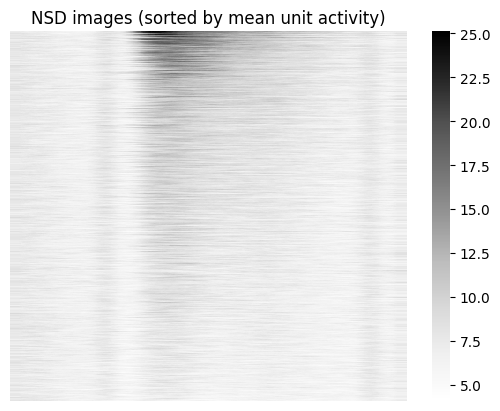

In [10]:
# 1. Compute mean activity for each image
row_means = M.mean(axis=1)  # shape: (num_images,)

# 2. Get sort order (indices of rows), from highest to lowest mean
row_order = np.argsort(row_means)[::-1]  # descending order

# 3. Plot using the sorted order
sns.heatmap(M[row_order, :], cmap=sns.color_palette('Greys', as_cmap=True))
plt.title('NSD images (sorted by mean unit activity)')
plt.axis('off')
plt.show()

(np.float64(0.0), np.float64(450.0), np.float64(1000.0), np.float64(0.0))

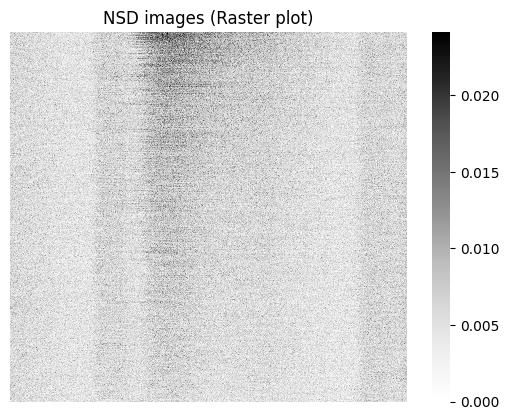

In [36]:
all_raster = np.stack(face_df['img_raster'].values)
raster = np.mean(all_raster, axis=0)

R = raster.T[:1000]
row_means = R.mean(axis=1) 
row_order = np.argsort(row_means)[::-1]

sns.heatmap(R[row_order, :], cmap=sns.color_palette('Greys', as_cmap=True))
plt.title('NSD images (Raster plot)')
plt.axis('off')

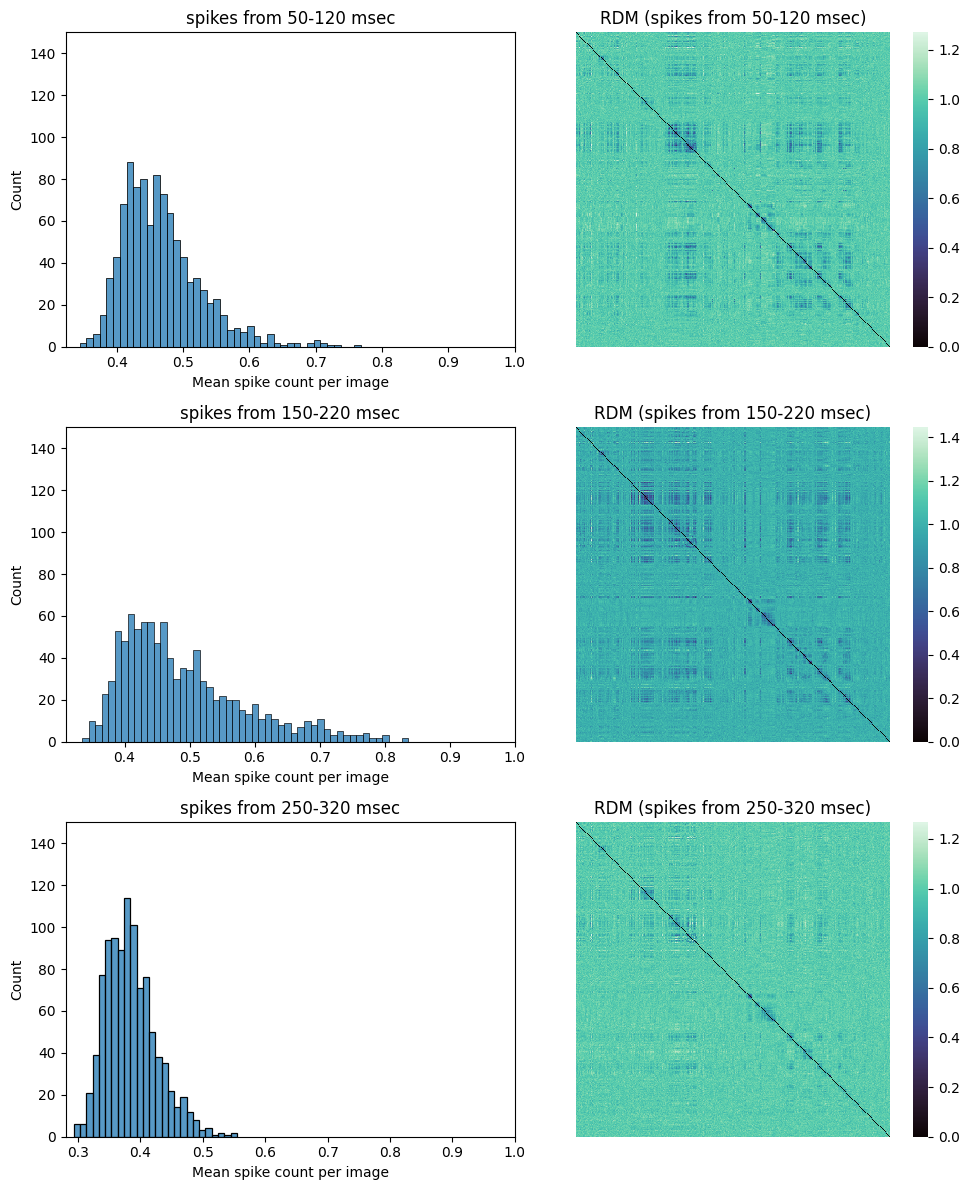

In [82]:
all_raster = np.stack(face_df['img_raster'].values)
raster = np.mean(all_raster, axis=0)

R = raster.T[:1000]

early_raster = all_raster[:, 100:170, :1000] # 70 - 150 msec
late_raster = all_raster[:, 200:270, :1000] # 170-250 msec
latelate_raster = all_raster[:, 300:370, :1000]
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

time_windows = [
    ('spikes from 50-120 msec', early_raster),
    ('spikes from 150-220 msec', late_raster),
    ('spikes from 250-320 msec', latelate_raster)
]

for row, (title, raster) in enumerate(time_windows):
    # Left: histogram
    ax = axes[row, 0]
    sspikes = np.sum(raster, axis=1)        # (units, images)
    x = np.mean(sspikes, axis=0)            # mean population activity per image
    sns.histplot(x, binwidth=0.01, ax=ax)
    ax.set_ylim(top=150)
    ax.set_xlim(right=1)
    ax.set_title(title)
    ax.set_xlabel('Mean spike count per image')
    ax.set_ylabel('Count')

    # Right: RDM
    ax = axes[row, 1]
    rdm = squareform(pdist(sspikes, metric='correlation'))  # shape (units, units)
    sns.heatmap(rdm, ax=ax, cmap='mako', square=True)  # only cbar for top row for less clutter
    ax.set_title('RDM (%s)' % title)
    ax.set_xlabel('Unit')
    ax.set_ylabel('Unit')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [72]:
unit = 'F_SI'
face_df = raster_data[(raster_data[unit]>0.5) & (raster_data['unit_type'] == 1) & (raster_data['snr_max'] > 20) & (raster_data['session'].isin([21,24,25,28,29,30,36,40]))]
face_df = face_df[~(face_df['img_raster'].isna())] # some sessions do not have raster data?
face_df['session'].unique(), len(face_df)

(array([21, 24, 25, 29, 30, 36, 40]), 42)

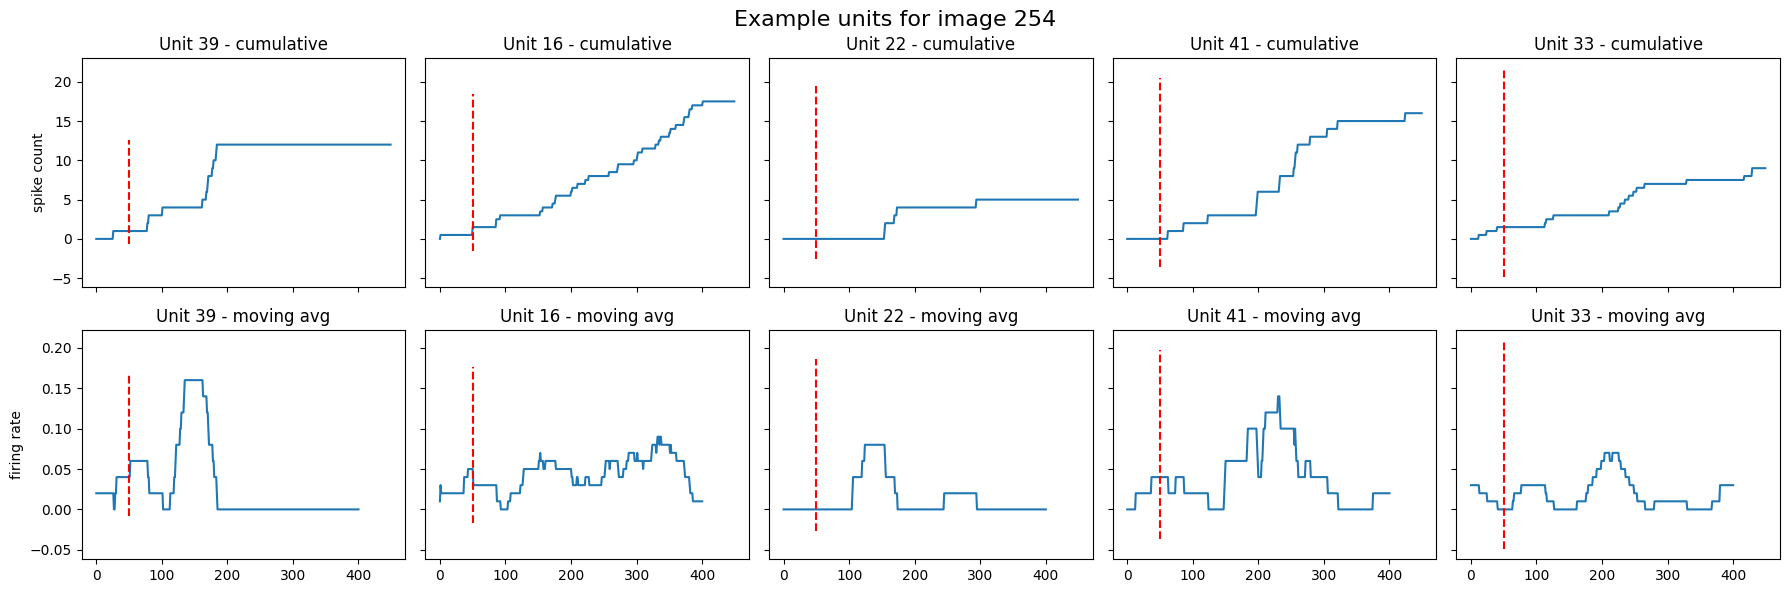

In [73]:
img_idx = 254
N = 50  # window for moving avg

random.seed(5)

example_units = random.sample(range(len(face_df)), 5)   # choose units you want to visualize

fig, axes = plt.subplots(2, 5, figsize=(18, 6), sharex='col', sharey='row')

for col, unit_idx in enumerate(example_units):
    # Get normalized spike history for this unit and image
    spike_history = face_df.iloc[unit_idx]['img_raster'][:, img_idx]
    spike_history = spike_history / spike_history.max()

    # --- Plot cumulative sum ---
    ax = axes[0, col]
    sns.lineplot(x=np.arange(len(spike_history)), y=np.cumsum(spike_history), ax=ax)
    ymin, ymax = ax.get_ylim()
    ax.vlines(x=50, ymin=ymin, ymax=ymax, colors='red', linestyle='dashed')
    ax.set_title(f'Unit {unit_idx} - cumulative')
    ax.set_ylabel('spike count')

    # --- Plot moving average ---
    ax = axes[1, col]
    moving_avg = np.convolve(spike_history, np.ones(N)/N, mode='valid')
    sns.lineplot(x=np.arange(len(moving_avg)), y=moving_avg, ax=ax)
    ymin, ymax = ax.get_ylim()
    ax.vlines(x=50, ymin=ymin, ymax=ymax, colors='red', linestyle='dashed')
    ax.set_title(f'Unit {unit_idx} - moving avg')
    ax.set_ylabel('firing rate')

plt.suptitle(f'Example units for image {img_idx}', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [128]:
datadir = '../datasets/NNN/'
fnames = utils.fnames(datadir)

cols = ['session', 'monkey', 'F_SI', 'B_SI', 'O_SI']
df = pd.DataFrame(columns=cols)

total_units = 0
for i, pair in tqdm(enumerate(fnames)):
    gus_fname = os.path.join(datadir, pair[0])
    proc_fname = os.path.join(datadir, pair[1])
    m = re.match(r'Processed_ses(\d+)_(\d{6})_M(\d+)_(\d+)\.mat', os.path.basename(proc_fname))
    if i == 28:
        print(f'skipping {proc_fname}...')
        continue
    if not m:
        print(f"Could not parse {proc_fname}")
        continue
    try:
        proc_data = scipy.io.loadmat(proc_fname)
        
        session_num = int(m.group(1))
        monkey = int(m.group(3))
        unit_types = proc_data['UnitType'][0]
        num_units = len(proc_data['UnitType'][0])

        bsi = proc_data['B_SI'].T.squeeze(); assert bsi.shape[0] == num_units
        osi = proc_data['O_SI'].T.squeeze(); assert osi.shape[0] == num_units
        fsi = proc_data['F_SI'].T.squeeze(); assert fsi.shape[0] == num_units
        
        for unit_idx in range(num_units):
            df.loc[len(df)] = {
                'session': session_num,
                'monkey': monkey,
                'F_SI': fsi[unit_idx],
                'B_SI': bsi[unit_idx],
                'O_SI': osi[unit_idx],
            }
        total_units += num_units

    except AssertionError as e:
        print(f"Assertion failed for {proc_fname or gus_fname}: {e}")
        continue
    except Exception as e:
        print(f"Error processing {proc_fname or gus_fname}: {e}")
        continue


30it [00:04,  6.47it/s]

skipping ../datasets/NNN/Processed_ses29_240920_M3_3.mat...


59it [00:11,  5.01it/s]


In [129]:
data['F_SI'] = df['F_SI']
data['B_SI'] = df['B_SI']
data['O_SI'] = df['O_SI']
data.to_pickle('../datasets/NNN/all_unit_data.pkl')